In [1]:
# import modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy.stats import zscore

# inline plots
%matplotlib inline


In [2]:
# read the data
dat_all = pd.read_excel('ADNI_ICM_random200.xlsx')
dat_all = dat_all.replace({'\'':''}, regex=True) # remove ' ' from data
dat_all = dat_all.rename(columns=lambda x:x.strip('\'')) # remove ' ' from column names
#dat_all

In [3]:
# select only the columns of interest
rois = ['IFG_opercularis_L','IFG_orbitalis_L','IFG_triangularis_L','LFOG_L','MFG_L','MFOG_L','PrCG_L','SFG_L',
       'IFG_opercularis_R','IFG_orbitalis_R','IFG_triangularis_R','LFOG_R','MFG_R','MFOG_R','PrCG_R','SFG_R']
info = ['Subject_ID', 'Gender', 'Age', 'Diagnosis']
columns = np.concatenate((info, rois), axis=0)
dat = dat_all[columns]
#dat

In [4]:
# split into Alzheimer's group and control group
ad = dat[dat.Diagnosis == 'AD/MCI']
control = dat[dat.Diagnosis == 'NORMAL']

In [5]:
#ad

In [6]:
#control

In [7]:
# split patient info and volume data
ad_info = ad[info]
ad_volume = ad[rois]
control_info = control[info]
control_volume = control[rois]

In [8]:
#ad_volume

In [9]:
#control_volume

In [10]:
# create new df with mean and standard deviation for both groups
mean_std = pd.DataFrame({'ad_mean':ad_volume.mean(), 'ad_std':ad_volume.std(), 
                         'control_mean':control_volume.mean(), 'control_std':control_volume.std()})
mean_std

,ad_mean,ad_std,control_mean,control_std
IFG_opercularis_L,3016.852941,501.002514,2976.343750,612.113700
IFG_orbitalis_L,3473.705882,591.191667,3427.140625,592.808914
IFG_triangularis_L,3065.566176,537.863534,3018.078125,500.433821
LFOG_L,4472.529412,591.059237,4364.015625,503.103779
MFG_L,8083.889706,1216.337877,8085.109375,1280.707941
MFOG_L,4309.022059,619.316570,4162.500000,494.428354
PrCG_L,11954.632353,1463.244000,11542.546875,1527.466311
SFG_L,10087.345588,1520.218115,9988.765625,1254.643094
IFG_opercularis_R,2849.308824,541.009612,2727.250000,518.554431
IFG_orbitalis_R,2720.977941,497.621773,2588.093750,466.202991


In [11]:
# calculate z-scores for each patient
ad_zscore = ad_volume.apply(zscore)
control_zscore = control_volume.apply(zscore)

In [12]:
#ad_zscore

In [13]:
#control_zscore

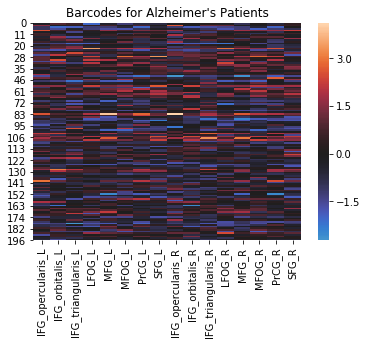

In [14]:
# heat map for all Alzheimer's patients
ax1 = sns.heatmap(ad_zscore, center=0)
ax1.set(title = "Barcodes for Alzheimer's Patients");

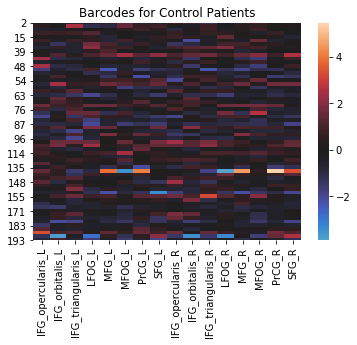

In [15]:
# heat map for all control patients
ax2 = sns.heatmap(control_zscore, center=0)
ax2.set(title = "Barcodes for Control Patients");